# Marketing Response Modelling Notebook

## Introduction
This notebook contains the supervised modelling for the marketing response. The data used comes after the preprocessinig done by the `preprocessing.py` file. The call for preprocessing was done via Terminal 

## Context/ Business Goal
The targeted company for this project is an **Organics** company that is selling **mail-ordered** products.

# Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

# Data Pipelines
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Misc
import pickle
import os

In [2]:
sns.set_style('whitegrid')

In [3]:
df_mailout = pd.read_parquet('data/refined/full_mailout_train_data_final.parquet')

In [4]:
df_mailout.shape

(35007, 303)

# Utils

In [ ]:
def evaluate_models(X,y,dict_models,cv):

    for i, (name, model) in enumerate(dict_models.items()):

        scores = cross_validate(model, X, y, cv=cv, scoring='roc_auc', n_jobs= -1, verbose = 1, return_train_score=True)

        scores['model'] = name

        if i == 0:

            records = [scores]

        else:

            records.append(scores)

    for i, r in enumerate(records):

        temp = pd.DataFrame.from_dict(r)

        if i == 0:

            results_df = temp
        
        else:

            results_df = pd.concat([results_df, temp])
        
    results_df.reset_index(inplace = True)

    results_df.rename(columns = {'index':'Fold'}, inplace = True)

    return results_df

def plot_train_results(train_results_data):

    fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

    sns.barplot(data = train_results_data,
                        x = 'Fold',
                        y = 'train_score',
                        hue = 'model',
                        ax = ax[0])

    sns.barplot(data = train_results_data,
                        x = 'Fold',
                        y = 'test_score',
                        hue = 'model',
                        ax = ax[1])

    ax[0].set_ylabel('ROC-AUC Score')

    ax[0].get_legend().remove()

    ax[0].set_title('Train data')

    ax[1].set_title('Test data')

    ax[1].legend(title = 'Model',bbox_to_anchor = (1.01,1), loc = 'upper left')

    ax[1].set_ylabel('')

    for a in ax:

        a.set_xlabel('Fold')

    plt.suptitle('Model Performance (ROC-AUC) Over K = 5 Folds for training data')

    plt.show()
    
def test_models(model_dict, X_train, y_train, X_test, y_test):
    
    model_result_dict = {'model':[],
                        'auc_score':[]}

    curve_data = []

    for name, model in model_dict.items():

        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_test)[:, 1]
        
        score_auc = roc_auc_score(y_test, y_pred)

        fpr, tpr, thresh = roc_curve(y_test, y_pred)

        curve_data.append((name, fpr, tpr, thresh))

        model_result_dict['model'].append(name)

        model_result_dict['auc_score'].append(score_auc)
        
    model_result_frame = pd.DataFrame().from_dict(model_result_dict)

    model_curve_data = pd.DataFrame(curve_data, columns = ['Model','FPR','TPR','Thresholds']).explode(['FPR','TPR','Thresholds'])

    return model_result_frame, model_curve_data
    
def plot_results(model_curve_data, model_result_frame):

    fig, axs = plt.subplots(1,2,figsize = (15,5))

    sns.lineplot(data = model_curve_data,
                x = 'FPR',
                y = 'TPR',
                hue = 'Model',
                ax = axs[0],
                errorbar=('ci',0),
                hue_order=['LR','DT','RF','XGB'])

    # Reference for ROC-AUC Plot
    sns.lineplot(x = [0,1],
                y = [0,1],
                linestyle = '--',
                color = 'black',
                linewidth = 0.5,
                ax = axs[0])

    sns.barplot(data = model_result_frame,
                x = 'model',
                y = 'auc_score',
                hue = 'model',
                hue_order = ['LR','DT','RF','XGB'],
                order = ['LR','DT','RF','XGB'],
                ax = axs[1],
                dodge=False)

    axs[0].set_title('ROC-AUC curve for different models')

    axs[0].set_xlabel('False Positive Rate (FPR)')

    axs[0].set_ylabel('True Positive Rate (TPR)')

    axs[0].legend(title = 'Models')

    for bars in axs[1].containers: axs[1].bar_label(bars, fmt='%.3f')

    axs[1].set_title('AUC-Score for each model')

    axs[1].set_ylabel('AUC-Score')

    axs[1].set_xlabel('Model')

    axs[1].get_legend().remove()

    plt.suptitle('Results for Test Set', size = 13, weight = 'bold')

    plt.show()

# Response variable

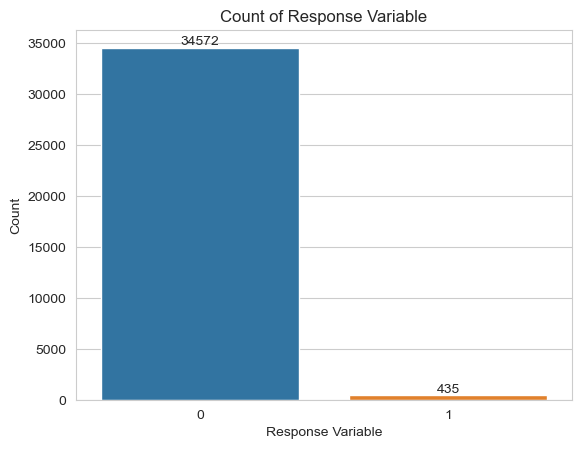

In [5]:
g = sns.countplot(data = df_mailout,
                    x = 'RESPONSE')

g.bar_label(g.containers[-1])

plt.title('Count of Response Variable')

plt.ylabel('Count')

plt.xlabel('Response Variable')

plt.show()

In [6]:
df_mailout['RESPONSE'].value_counts(normalize = True)

0    0.987574
1    0.012426
Name: RESPONSE, dtype: float64

The data is HEAVILY imbalanced. A little more than 1% actually responded to the mailing.  
This is not inherently bad. Some methods can be used like up- or downsampling but not necessairly.  
Either way, given this hard imbalace, accuracy should not be used since in this context it is a biased metric

# Segmenting variable types

In [7]:
census_var_types = pd.read_csv('data/trusted/var_type_list.csv')

In [8]:
census_var_types.head()

,Attribute,Type,dtype
0,AGER_TYP,nominal,int
1,ALTERSKATEGORIE_GROB,interval,int
2,ALTER_HH,interval,int
3,ANREDE_KZ,binary,int
4,ANZ_HAUSHALTE_AKTIV,numeric,float


In [9]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [10]:
for col in binary_vars:
    
    try:
        print(col, df_mailout[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0 1]
ANZ_KINDER [0 1]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 [0 1]
OST_WEST_KZ [1 0]
VERS_TYP [2 1]


In [11]:
df_mailout['ANREDE_KZ'] = df_mailout['ANREDE_KZ'] - 1

df_mailout['VERS_TYP'] = df_mailout['VERS_TYP'] - 1

In [12]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, df_mailout.columns)

In [13]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, df_mailout.columns)

In [14]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, df_mailout.columns)

In [15]:
num_cols = df_mailout.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR','RESPONSE'])

In [16]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == len(df_mailout.columns.drop('RESPONSE'))

# Splitting Data

In [17]:
X = df_mailout.drop(columns = ['LNR','RESPONSE']).reset_index(drop = True)

y = df_mailout['RESPONSE'].reset_index(drop = True)

In [18]:
feature_list = df_mailout.columns.drop(['LNR','RESPONSE'])

nominal_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in nominal_vars]

interval_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in interval_vars]

num_vars_pos = [feature_list.get_loc(col) for col in X.columns if col in num_cols]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify = y,random_state=42)

In [20]:
y_train.value_counts(normalize = True)

0    0.987574
1    0.012426
Name: RESPONSE, dtype: float64

In [21]:
y_test.value_counts(normalize = True)

0    0.987575
1    0.012425
Name: RESPONSE, dtype: float64

# Testing base models
Vanilla models to pick best option for tuning

In [22]:
# Models to be tested
dt = DecisionTreeClassifier(max_depth=3, class_weight='balanced')

rf = RandomForestClassifier(max_depth = 3,class_weight='balanced_subsample',random_state=42, n_jobs=-1)

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
xgb = XGBClassifier(scale_pos_weight = 80,
                    max_depth = 2,
                    eta = 0.1,
                    n_jobs = -1,
                    random_state = 42,
                    objective = 'binary:logistic',
                    eval_metric = 'auc' )

# Baseline
lr = LogisticRegression(n_jobs = -1,class_weight='balanced',random_state=42)

Initial models with a few parameters to avoid overfitting.  
Comparison Baseline: Logistic Regression

In [23]:
transformer_no_ohe_interval = make_column_transformer(
                                                        (StandardScaler(), list(interval_vars) + list(num_cols)),
                                                        (OneHotEncoder(),sorted(nominal_vars_pos)),
                                                        remainder = 'passthrough'
                                                        )

transformer_ohe_interval = make_column_transformer(
                                                    (StandardScaler(), num_vars_pos),
                                                    (OneHotEncoder(handle_unknown = 'ignore'), sorted(nominal_vars_pos + interval_vars_pos)), #  Using LE for imblearn purposes
                                                    remainder = 'passthrough'
                                                    )

In [24]:
# Models to be tested
pipe_dt = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('DT',dt)])

pipe_rf = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('XGB',xgb)])

pipe_lr = Pipeline([('scaler_ohe',transformer_no_ohe_interval),('LR',lr)])

In [25]:
models_dict = {'Decision Tree':pipe_dt,
               'Random Forest':pipe_rf,
               'XGBoost':pipe_xgb,
               'LogisticRegression':pipe_lr}

In [26]:
skfold = StratifiedKFold(n_splits = 5)

## Testing interval vars w/o OHE

In [28]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.3s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.5s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.1s finished


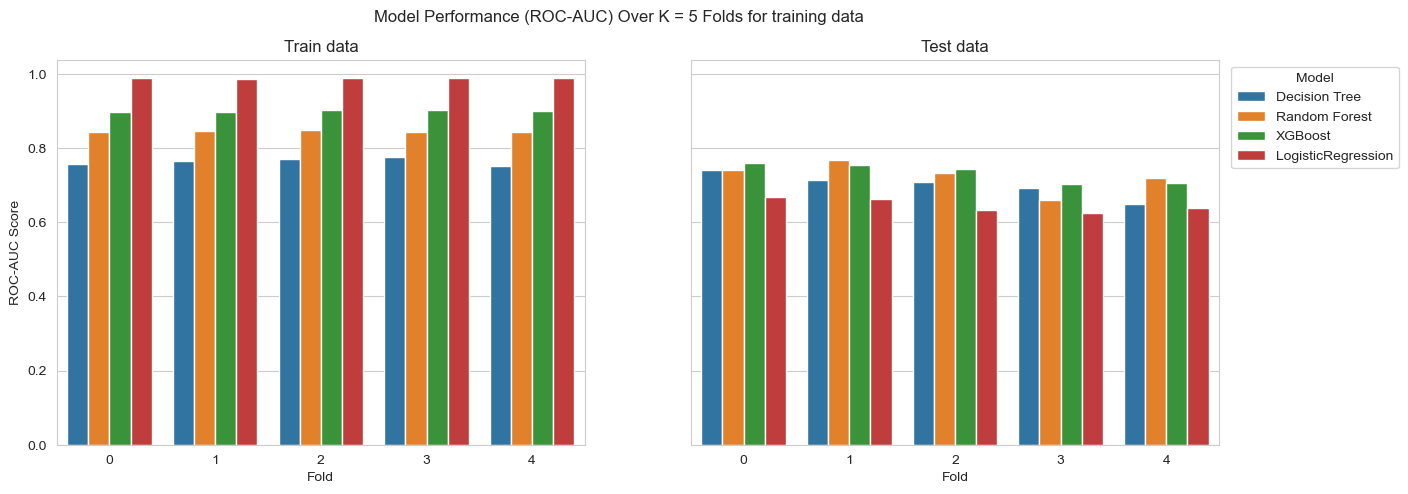

In [99]:
plot_train_results(results_df)

In [32]:
results_df.groupby('model')[['test_score','train_score']].mean()

,test_score,train_score
model,,
Decision Tree,0.700377,0.738477
LogisticRegression,0.637067,0.889336
Random Forest,0.691386,0.838235
XGBoost,0.728122,0.903537


Due to the difference between train and test set performance, the models seem to overfit on training data.  
This is somewhat expected, since there is a heavy unbalance in data.

## Testing interval vars w/ OHE

In [100]:
# Models to be tested
pipe_dt_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('DT',dt)])

pipe_rf_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('RF',rf)])

# Instantiating an XGB to match the closest possible characteristics with balanced class_weights
pipe_xgb_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('XGB',xgb)])

pipe_lr_ohe_int = Pipeline([('scaler_ohe',transformer_ohe_interval),('LR',lr)])

In [101]:
models_dict_ohe_interval = {'Decision Tree':pipe_dt_ohe_int,
                            'Random Forest':pipe_rf_ohe_int,
                            'XGBoost':pipe_xgb_ohe_int,
                            'LogisticRegression':pipe_lr_ohe_int}

In [102]:
results_df = evaluate_models(X_train, y_train, dict_models = models_dict_ohe_interval, cv = skfold)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.9s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.8s finished


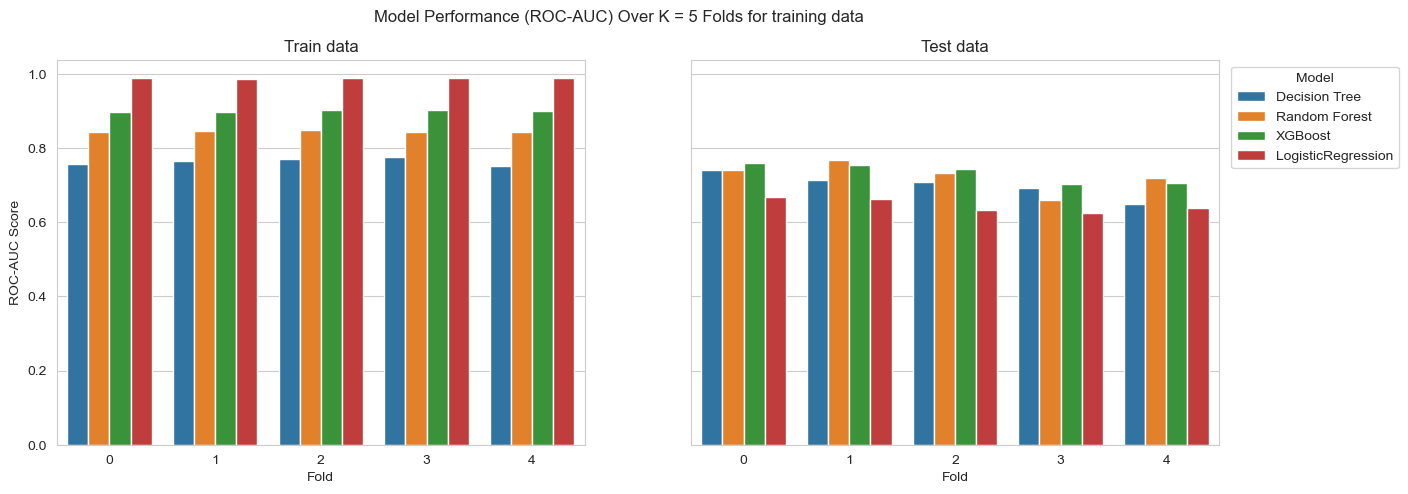

In [103]:
plot_train_results(results_df)

In [104]:
results_df.groupby('model')[['test_score','train_score']].mean()

,test_score,train_score
model,,
Decision Tree,0.701264,0.763959
LogisticRegression,0.645299,0.989073
Random Forest,0.724597,0.845105
XGBoost,0.733472,0.900662


# Hyperparameter Tuning - Variables with OHE

In [38]:
dt_params = {'DT__max_depth':[2,3,5,6],
             'DT__min_samples_split':[2,5,10],
             'DT__min_samples_leaf':[1,3,5]}

rf_params = {'RF__n_estimators':[100,200],
             'RF__max_depth':[2,3,4]}

xgb_params = {'XGB__n_estimators':[100,150],
              'XGB__max_depth':[2,3],
              'XGB__learning_rate':[0.1,0.2],
              'XGB__alpha':[0,1,2.5]}

In [39]:
model_search_list = list(zip([pipe_dt, pipe_rf, pipe_xgb],
                                [dt_params, rf_params, xgb_params],
                                ['DT','RF','XGB']))

In [40]:
cross_vals = {'DT':None,
              'RF':None,
              'XGB':None}

for model, params, name in model_search_list:

    print(f'Running for {name}')

    cv = GridSearchCV(model,
                        params,
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        cv = skfold,
                        verbose = 1)
        
    cv.fit(X_train, y_train)

    print('Mean Scores:',cv.cv_results_['mean_test_score'],'\n',
            'Rank:',cv.cv_results_['rank_test_score'], end = '\n\n')
    
    cross_vals[name] = cv

Running for DT
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean Scores: [0.69681365 0.69681365 0.69681365 0.69681365 0.69681365 0.69681365
 0.69681365 0.69681365 0.69681365 0.700377   0.700377   0.700377
 0.700377   0.700377   0.700377   0.700377   0.700377   0.700377
 0.68675043 0.68675043 0.68671634 0.68678554 0.68675043 0.68671454
 0.68671555 0.68675145 0.68668045 0.682334   0.6822341  0.68192787
 0.68209573 0.6822573  0.68218916 0.68145753 0.68186387 0.68172307] 
 Rank: [10 10 10 10 10 10 10 10 10  1  1  1  1  1  1  1  1  1 21 21 24 19 21 26
 25 20 27 28 30 33 32 29 31 36 34 35]

Running for RF
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Scores: [0.6816606  0.68563065 0.6913861  0.69072502 0.69688365 0.69673553] 
 Rank: [6 5 3 4 1 2]

Running for XGB
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mean Scores: [0.72812221 0.7218592  0.72028935 0.71217513 0.7174558  0.70596929
 0.69542622 0.69503787 0.72817808 0.72206872 0.7202090

In [49]:
for k, v in cross_vals.items(): print(k, f'Best Score: {v.best_score_}')

DT Best Score: 0.7003770041400589
RF Best Score: 0.6968836548540358
XGB Best Score: 0.7296084483801176


In [52]:
for name, c in cross_vals.items():

    with open(f'models/{name}_no_ohe_best_estimator.pkl', 'wb') as file:

            pickle.dump(c.best_estimator_, file)

# Hyperparameter Tuning - RF with OHE of interval vars

In [43]:
model_search_list_alt = list(zip([pipe_dt_ohe_int, pipe_rf_ohe_int, pipe_xgb_ohe_int],
                                [dt_params, rf_params, xgb_params],
                                ['DT','RF','XGB']))

In [44]:
cross_vals_alt = {'DT':None,
                  'RF':None,
                  'XGB':None}

for model, params, name in model_search_list_alt: 

    print(f'Running for {name}')

    cv = GridSearchCV(model,
                        params,
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        cv = skfold,
                        verbose = 1)
        
    cv.fit(X_train, y_train)

    print('Mean Scores:',cv.cv_results_['mean_test_score'],'\n',
            'Rank:',cv.cv_results_['rank_test_score'], end = '\n\n')
    
    cross_vals_alt[name] = cv

Running for DT
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean Scores: [0.71377133 0.71377133 0.71377133 0.71377133 0.71377133 0.71377133
 0.71377133 0.71377133 0.71377133 0.70126433 0.70126433 0.70126433
 0.70126433 0.70126433 0.70126433 0.70126433 0.70126433 0.70126433
 0.67173813 0.67166995 0.67171437 0.67171437 0.67174976 0.67164877
 0.67392086 0.67363365 0.67381936 0.63406844 0.63400593 0.63384426
 0.63400496 0.63397365 0.63378047 0.63585389 0.63595127 0.63582265] 
 Rank: [ 1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10 10 23 26 24 24 22 27
 19 21 20 31 32 35 33 34 36 29 28 30]

Running for RF
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean Scores: [0.72233988 0.72545908 0.72459731 0.72777255 0.72022312 0.72368254] 
 Rank: [5 2 3 1 6 4]

Running for XGB
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mean Scores: [0.73347209 0.72478828 0.72037777 0.70780303 0.71867376 0.70509079
 0.69090601 0.68906003 0.73456497 0.7268779  0.718

In [50]:
for k, v in cross_vals_alt.items(): print(k, f'Best Score: {v.best_score_}')

DT Best Score: 0.7137713255029126
RF Best Score: 0.7277725513923696
XGB Best Score: 0.734564972465345


In [53]:
for name, c in cross_vals_alt.items():

    with open(f'models/{name}_ohe_best_estimator.pkl', 'wb') as file:

            pickle.dump(c.best_estimator_, file)

# Predictions on test set

In [55]:
model_dict_no_ohe = {}

for k, v in cross_vals.items():

    model_dict_no_ohe[k] = v.best_estimator_

In [64]:
model_dict_ohe = {}

for k, v in cross_vals_alt.items():

    model_dict_ohe[k] = v.best_estimator_

In [83]:
# Baseline Result
model_dict_no_ohe['LR'] = pipe_lr

model_dict_ohe['LR'] = pipe_lr_ohe_int

In [74]:
result_no_ohe, curve_no_ohe = test_models(model_dict_no_ohe,
                                            X_train,
                                            y_train,
                                            X_test,
                                            y_test)

In [76]:
result_no_ohe

,model,auc_score
0,DT,0.706351
1,RF,0.700619
2,XGB,0.713069
3,LR,0.629021


In [84]:
result_ohe, curve_ohe = test_models(model_dict_ohe,
                                            X_train,
                                            y_train,
                                            X_test,
                                            y_test)

In [85]:
result_ohe

,model,auc_score
0,DT,0.729312
1,RF,0.733350
2,XGB,0.715122
3,LR,0.633849


## Result Plot

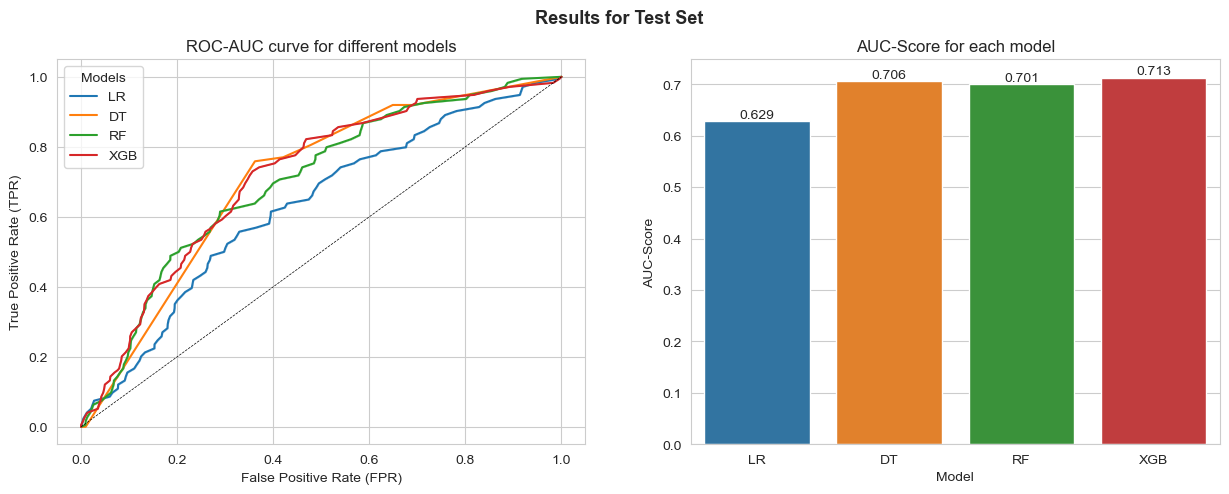

In [94]:
plot_results(curve_no_ohe, result_no_ohe)

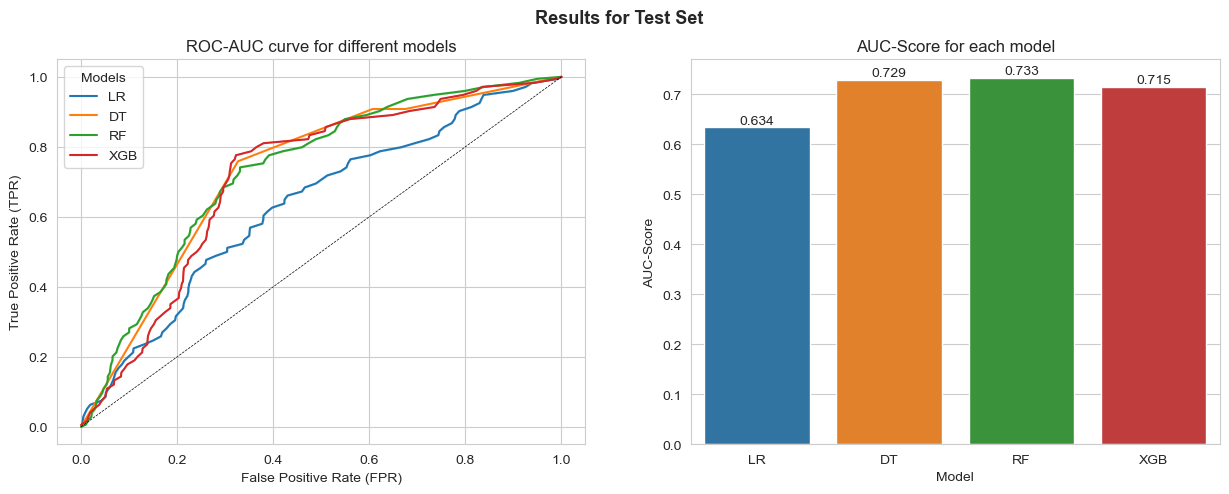

In [95]:
plot_results(curve_ohe, result_ohe)

# Feature importance of RF

In [121]:
data = list(zip(X_train.columns, model_dict_ohe['RF'].steps[1][1].feature_importances_))

In [125]:
feature_importances = pd.DataFrame(data, columns = ['columns','feature importance'])

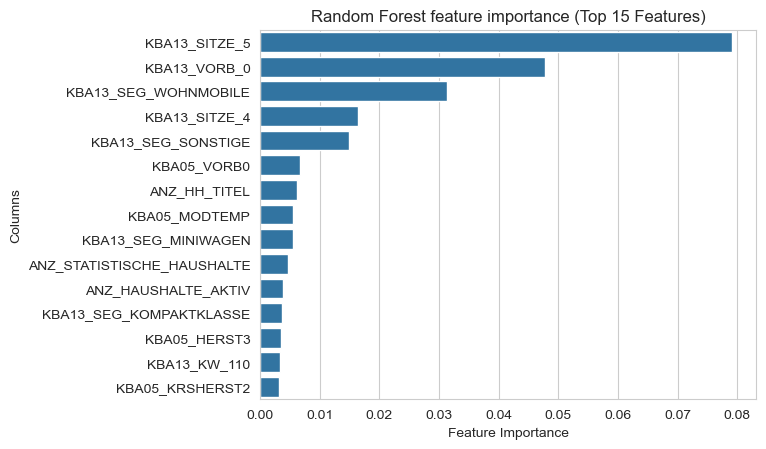

In [132]:
sns.barplot(data = feature_importances.nlargest(15,'feature importance'),
            x = 'feature importance',
            y = 'columns',
            color = 'tab:blue')

plt.ylabel('Columns')

plt.xlabel('Feature Importance')

plt.title('Random Forest feature importance (Top 15 Features)')

plt.show()